In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

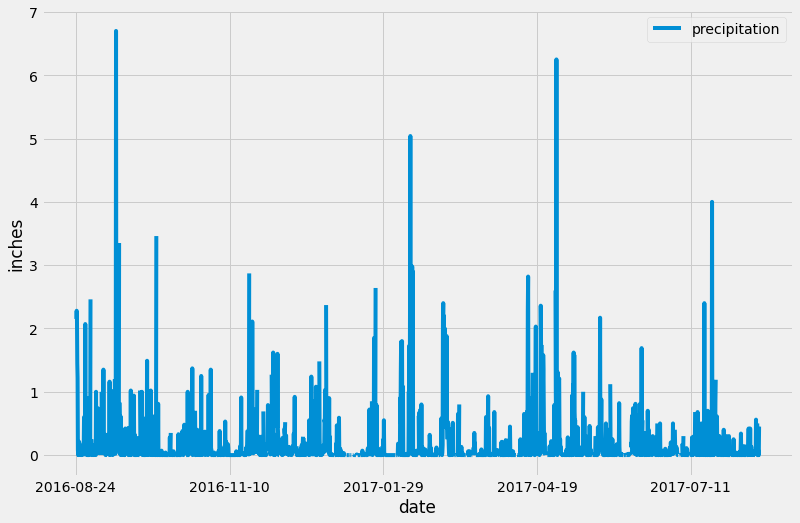

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_dt = dt.datetime.strptime(recent[0], '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
last_year_dt = dt.datetime(recent_dt.year - 1,recent_dt.month,recent_dt.day,0,0)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > last_year_dt)

# Save the query results as a Pandas DataFrame and set the index to the date column
measurement_df = pd.DataFrame(results).set_index('date')
measurement_df.rename(columns={'prcp':'precipitation'},inplace=True)

# Sort the dataframe by date
sorted_df = measurement_df.sort_values(by='date')

# # Use Pandas Plotting with Matplotlib to plot the data
sorted_df.plot(figsize=(12,8))
plt.ylabel('inches')
plt.show()


In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sorted_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])
    
print("")

columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
# Design a query to calculate the total number stations in the dataset
session.query(Station.id).count()

9

In [14]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_count = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
min_temp = session.query(func.min(Measurement.tobs).filter(Measurement.station == 'USC00519281'))[0][0]
avg_temp = session.query(func.avg(Measurement.tobs).filter(Measurement.station == 'USC00519281'))[0][0]
max_temp = session.query(func.max(Measurement.tobs).filter(Measurement.station == 'USC00519281'))[0][0]
print(f"The minimum temperature for station USC00519281 is {min_temp}.")
print(f"The average temperature for station USC00519281 is {round(avg_temp,1)}.")
print(f"The maximum temperature for station USC00519281 is {max_temp}.")

The minimum temperature for station USC00519281 is 54.0.
The average temperature for station USC00519281 is 71.7.
The maximum temperature for station USC00519281 is 85.0.


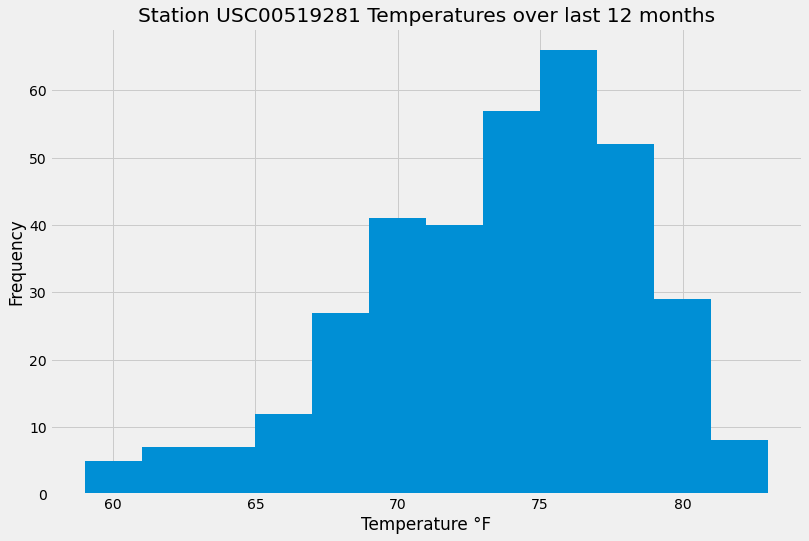

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_temps = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date > last_year_dt)

temps_df = pd.DataFrame(station_temps)

temps_df.hist(figsize=(12,8),bins=12)
plt.title('Station USC00519281 Temperatures over last 12 months')
plt.xlabel('Temperature °F')
plt.ylabel('Frequency')
plt.show()


# Close session

In [17]:
# Close Session
session.close()